In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For deep learning
import tensorflow as tf
import keras as keras
import keras.layers as layers
import keras.initializers as initializers

import random

# For solving eq
from scipy import integrate

# For environment
import gym
from gym import spaces

In [2]:
tf.random.set_seed(2304)
np.random.seed(2304)

In [3]:
N_ACTIONS = 5
N_STATE = 2
max_steps = 200

# Solver

In [4]:
def derivative(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])

In [5]:
class Plotter:

  def __init__(self, Nt, tmax) -> None:
    
    self.Nt = Nt
    self.tmax = tmax
    self.alphas, self.deltas = [], []
    self.t_vec  = []
    self.X_vec, self.Y_vec = [], []

  def add_data(self, new_t, res, new_alpha, new_delta) -> None:

    offset = self.tmax / (self.Nt - 1) + self.t_vec[-1] if len(self.t_vec) > 0 else self.tmax / (self.Nt - 1)
    new_t = new_t + offset
    self.t_vec = np.concatenate([self.t_vec, new_t])
    new_x, new_y = res.T
    new_alpha_vec = np.ones(shape=new_x.shape) * new_alpha
    new_delta_vec = np.ones(shape=new_x.shape) * new_delta
    self.X_vec = np.concatenate([self.X_vec, new_x])
    self.Y_vec = np.concatenate([self.Y_vec, new_y])
    self.alphas = np.concatenate([self.alphas, new_alpha_vec])
    self.deltas = np.concatenate([self.deltas, new_delta_vec])
    
    return

  def plot(self):
    # plot it
    f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1.5, 1.5]}, figsize=(8,7))

    a0.plot(self.t_vec, self.X_vec)
    a0.plot(self.t_vec, self.Y_vec)
    a0.set(ylim=(0, 10 + max(np.max(self.X_vec), np.max(self.Y_vec))))
    a0.hlines(y=4, xmin=self.t_vec[0], xmax=self.t_vec[-1], linestyles='dashed')
    a0.set_xlabel('Time t, [days]')
    a0.set_ylabel('Population')
    a0.legend(['Prey', 'Predator', 'Extinction'])

    a1.plot(self.t_vec, self.alphas, color='red')
    a1.set_yticks([0.5, 0.75, 1, 1.25, 1.5])
    a1.set(ylim=(0, 2))
    a1.set_xlabel('Time t, [days]')
    a1.legend(['alpha'])

    a2.plot(self.t_vec, self.deltas, color='blue')
    a2.set_yticks([0.75, 1, 1.25, 1.5, 1.75])
    a2.set(ylim=(0, 2))
    a2.set_xlabel('Time t, [days]')
    a2.legend(['delta'])


    f.tight_layout()

    return

In [6]:
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""

  metadata = {'render.modes': ['human']}

  def __init__(self, X0, params, N_ACTIONS):
    super(CustomEnv, self).__init__()

    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_ACTIONS)
    self.action_vec  = [[a,b] for a in np.linspace(0.5, 1.5, N_ACTIONS) for b in np.linspace(0.5, 1.5, N_ACTIONS) ]
    self.observation_space = spaces.Box(low=np.array([0,0]), 
                                        high=np.array([1000,1000]), dtype=np.float64)

    #Params related to differential equation
    self.X0, self.Xt, self.alpha0, self.delta0 = np.array(X0), np.array(X0), params['alpha'], params['delta']
    self.params = params
    self.Nt, self.tmax = 100, 2.
    self.plotter = Plotter(Nt=self.Nt, tmax=self.tmax)


  def reset(self):
    self.params['alpha'] = self.alpha0
    self.params['delta'] = self.delta0
    self.Xt = self.X0
    self.plotter = Plotter(Nt=100, tmax=2)

  def get_action_value(self, action):
    return self.action_vec[action]

  def get_reward(self, res, step_counter, extinction_threshold = [4, 5]):

    done = False

    if np.min(res) < extinction_threshold[0]:
      reward = -1000
      done = True
      # print('----- Extinction -----')

    #elif np.min(res) < extinction_threshold[1]:
    #  reward = -10

    elif step_counter == max_steps:
      reward = 500
    
    else:
      reward = -1

    return reward, done

  def step(self, action, step_counter, inplace=False, plot=False, train=False):

    # Assert that it is a valid action 
    #assert self.action_space.contains([action[0], action[1]]), "Invalid Action"

    # Apply action
    self.params['alpha'] = self.get_action_value(action)[0]
    self.params['delta'] = self.get_action_value(action)[1]

    # Evolution of differential equation
    t = np.linspace(0., self.tmax, self.Nt)
    res = integrate.odeint(derivative, self.Xt, t, args = (self.params['alpha'], 
                                                           self.params['beta'], 
                                                           self.params['delta'], 
                                                           self.params['gamma']))

    # Eventual plot of the equation
    if inplace:
      self.Xt = np.array(res[-1])
      self.plotter.add_data(new_t=t, res=res, new_alpha=self.params['alpha'], 
                            new_delta=self.params['delta'])

    if not train:
      print("alpha: ", self.params['alpha'], "delta: ", self.params['delta'])
    
    if plot:
      self.plot_evolution(res, t)

    reward, done = self.get_reward(res, step_counter)

    return self.Xt, reward, done, []


  def plot_evolution(self, res, t):
    
    x, y = res.T
    plt.figure()
    plt.grid()
    plt.title("odeint method")
    plt.plot(t, x, '-b', label = 'Rabbits')
    plt.plot(t, y, '-r', label = "Lynxes")
    plt.xlabel('Time t, [days]')
    plt.ylabel('Population')
    plt.legend()

    plt.show()

    return


## Example

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


alpha:  0.5 delta:  0.75


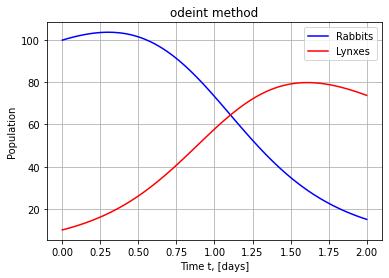

(array([15.00472651, 73.81226004]), -1, False, [])

In [7]:
X0 = [100, 10]
params = {'alpha' : 0.55, 'beta' : 0.028,    #'alpha' : 0.55, 'beta' : 0.028,
          'delta' : 0.84,'gamma' : 0.026}    #'delta' : 0.84,'gamma' : 0.026

env = CustomEnv(X0, params, N_ACTIONS)
env.step(1, 0, inplace=True, plot=True)

alpha:  0.5 delta:  0.75


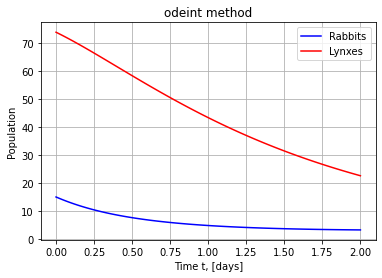

(array([ 3.24719963, 22.5867745 ]), -1000, True, [])

In [8]:
#To make more steps 
env.step(1, 0, inplace=True, plot=True)

# Network

In [9]:
def construct_q_network(N_STATE, N_ACTIONS):
    """Construct the critic network with q-values per action as output"""

    inputs = layers.Input(shape=(N_STATE,))  # input dimension
    hidden1 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(inputs)
    hidden2 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(hidden1)
    #hidden3 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(hidden2)
    #hidden4 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(hidden3)
    #hidden5 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(hidden4)
    q_values = layers.Dense(N_ACTIONS, activation="linear")(hidden2)

    q_network = keras.Model(inputs=inputs, outputs=[q_values])

    return q_network

# Deep Q-Learning

In [10]:
def deepqlearning(sim_input, sim_output, show_plot=False):

    num_episodes = sim_input.num_episodes
    discount = sim_input.discount
    lr = sim_input.lr
    epsilon = sim_input.epsilon

    show_plot = show_plot

    def mean_squared_error_loss(q_value, reward):
        """Compute mean squared error loss"""

        return 0.5 * (q_value - reward) ** 2 

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    alpha_cache = []
    delta_cache = []
    rewards_cache = np.zeros(num_episodes)

    q_network = construct_q_network(N_STATE, N_ACTIONS*N_ACTIONS)
    target_network = tf.keras.models.clone_model(q_network)  # Copy network architecture
    target_network.set_weights(q_network.get_weights())  # Copy network weights

    replay_buffer = []
    min_buffer_size = 10  # 10
    batch_size = 10
    training = True
    learning_frequency = batch_size  # Set equal to batch size for fair comparisons
    update_frequency_target_network = 10
    states_final_policy = []


    for episode in range(num_episodes):

        step_counter = 0
        done = False

        if not episode % 1:
            print("***** Episode ", episode, " *****")

        # Set to target policy at final episodes
        if episode == len(range(num_episodes)) - 1:
            training = False

        # Initialize environment and agent position
        X0 = np.random.normal([100, 10], [10, 2])
        environment = CustomEnv(X0, params, N_ACTIONS)
        loss_list = []

        while not done:
            with tf.GradientTape() as tape:

                step_counter += 1

                # Get current state
                state = environment.Xt

                if not training:
                  states_final_policy.append([state[0], state[1]])

                # Select action using ε-greedy policy

                # Obtain q-values from network
                q_values = tf.stop_gradient(q_network(state[np.newaxis,:]))

                sample_epsilon = np.random.rand()
                if sample_epsilon <= epsilon and training:
                #if sample_epsilon <= max(epsilon/np.log(episode+2), 0.1) and training:
                    # Select random action
                    action = np.random.choice(N_ACTIONS*N_ACTIONS)
                else:
                    # Select action with highest q-value
                    action = int(np.argmax(q_values[0]))

                # Determine next state
                next_state, reward, done, _ = environment.step(action, step_counter, inplace=True, plot=show_plot, train=training)

                # Compute and store reward
                rewards_cache[episode] += reward

                # Store observation in replay buffer
                observation = [state, action, reward, next_state]
                replay_buffer.append(observation)

                # Update network if (i) buffer sufficiently large and (ii) learning frequency matched and (iii) in training
                if ( len(replay_buffer) >= min_buffer_size
                     and step_counter % learning_frequency == 0
                     and training ):

                    observations = random.choices(replay_buffer, k=batch_size)
                    loss_value = 0

                    # Compute mean loss
                    for observation in observations:
                        state = observation[0]
                        action = observation[1]
                        reward = observation[2]
                        next_state = observation[3]

                        # Select next action with highest q-value
                        # Check whether game is over (ignoring # steps)
                        _ , _, done, _ = environment.step(action, step_counter, inplace=False, plot=False, train = True)
                        
                        if done:
                            next_q_value = 0
                        else:
                            next_q_values = tf.stop_gradient(target_network(next_state[np.newaxis,:]) )
                            next_action = np.argmax(next_q_values[0])
                            next_q_value = next_q_values[0, next_action]

                        observed_q_value = reward + (discount * next_q_value)

                        q_values = q_network(state[np.newaxis,:])
                        current_q_value = q_values[0, action]

                        loss_value += mean_squared_error_loss( observed_q_value, current_q_value )

                    # Compute mean loss value
                    loss_value /= batch_size

                    # Compute gradients
                    grads = tape.gradient(loss_value, q_network.trainable_variables)

                    # Apply gradients to update q-network weights
                    opt.apply_gradients(zip(grads, q_network.trainable_variables))

                    # Periodically update target network
                    if episode % update_frequency_target_network == 0:
                        target_network.set_weights(q_network.get_weights())
                    
                    loss_list.append(loss_value)

                alpha_cache.append(environment.params['alpha'])
                delta_cache.append(environment.params['delta'])
                
                if step_counter >= max_steps:
                  done = True

        print("counter: ", step_counter, '-------', ' loss : ', tf.math.reduce_mean(loss_list))

    sim_output.step_cache.append([alpha_cache, delta_cache])
    sim_output.reward_cache.append(rewards_cache)

    sim_output.env_cache.append(environment)
    sim_output.name_cache.append("Deep Q-learning")

    return q_network, sim_output, states_final_policy, environment

# Main

In [11]:
class sim_init:
    def __init__(self, num_episodes, discount, lr, epsilon):
        self.num_episodes = num_episodes  # Number of training episodes
        self.discount = discount          # Discount rate γ 0.9
        self.lr = lr                      # Learning rate α 0.001
        self.epsilon = epsilon            # Exploration rate ε

    def __str__(self):
        return "# episodes: " + str(self.num_episodes) + "gamma: " + str(self.gamma) \
                + "lr: " + str(self.lr) + "epsilon: " + str(self.epsilon)

class sim_output:
    def __init__(self, rewards_cache, step_cache, env_cache, name_cache):
        self.reward_cache = rewards_cache  # list of rewards
        self.step_cache = step_cache       # list of steps
        self.env_cache = env_cache         # list of final paths
        self.name_cache = name_cache       # list of algorithm names

sim_output = sim_output( rewards_cache=[], step_cache=[], env_cache=[], name_cache=[] )

In [12]:
X0 = [100, 10]
params = {'alpha' : 0.55, 'beta' : 0.028,    #'alpha' : 0.55, 'beta' : 0.028,
          'delta' : 0.84,'gamma' : 0.026}    #'delta' : 0.84,'gamma' : 0.026

In [13]:
sim_input = sim_init(num_episodes=2000, discount=0.9, lr=0.00001, epsilon=0.1)
q_network, sim_output, states_final_policy, env = deepqlearning(sim_input, sim_output)

***** Episode  0  *****
counter:  7 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  1  *****


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


counter:  30 -------  loss :  tf.Tensor(33586.816, shape=(), dtype=float32)
***** Episode  2  *****
counter:  7 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  3  *****
counter:  40 -------  loss :  tf.Tensor(37400.76, shape=(), dtype=float32)
***** Episode  4  *****
counter:  6 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  5  *****
counter:  4 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  6  *****
counter:  15 -------  loss :  tf.Tensor(1880.4226, shape=(), dtype=float32)
***** Episode  7  *****
counter:  2 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  8  *****
counter:  30 -------  loss :  tf.Tensor(31729.678, shape=(), dtype=float32)
***** Episode  9  *****
counter:  2 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  10  *****
counter:  8 -------  loss :  tf.Tensor(nan, shape=(), dtype=float32)
***** Episode  11  *****
counter:  11 -------  loss :  tf.Tensor(2

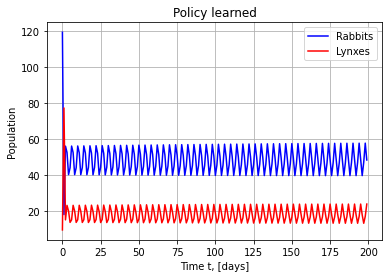

In [14]:
x, y = np.transpose(states_final_policy)[0], np.transpose(states_final_policy)[1]
plt.figure()
plt.grid()
plt.title("Policy learned")
plt.plot(range(len(x)), x, '-b', label = 'Rabbits')
plt.plot(range(len(y)), y, '-r', label = "Lynxes")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()

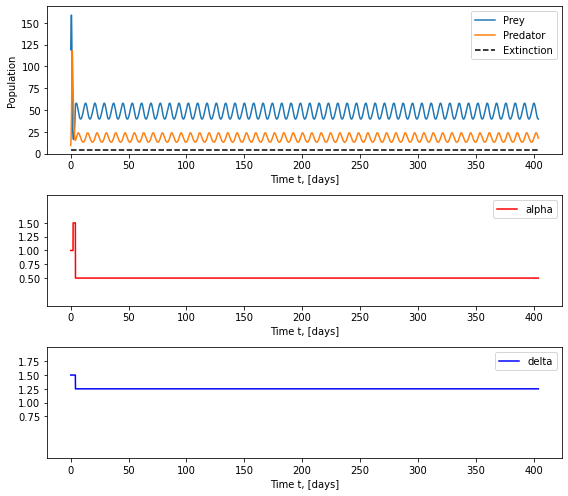

In [15]:
env.plotter.plot()

In [16]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [18]:
#q_network.save('../content/drive/Othercomputers/Il mio laptop/final-project/Models/network_alpha_delta_variabili') 

INFO:tensorflow:Assets written to: ../content/drive/Othercomputers/Il mio laptop/final-project/Models/network_alpha_delta_variabili/assets


ALPHA E DELTA con 5 

inputs = layers.Input(shape=(N_STATE,))  # input dimension  \\
idden1 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(inputs)   \\
hidden2 = layers.Dense(32, activation="relu", kernel_initializer=initializers.he_normal())(hidden1)   \\
q_values = layers.Dense(N_ACTIONS, activation="linear")(hidden2)

sim_input = sim_init(num_episodes=2000, discount=0.9, lr=0.00001, epsilon=0.1)
